# Statistical shape modelling with pyssam

This statistical shape modelling example visualises modes of left lower lung lobe shape correlations. 

In [20]:
import pyssam

In [21]:
from copy import copy
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

First, we source landmark data to use in our shape model

In [22]:
LANDMARK_DIR = "../example_data/lung_landmarks/"
landmark_files = glob(LANDMARK_DIR + "/landmarks*.csv")
if len(landmark_files) == 0:
  raise AssertionError(
    "The directories you have declared are empty.",
    "\nPlease check your input arguments.",
  )

landmark_coordinates = np.array(
  [np.loadtxt(l, delimiter=",") for l in landmark_files]
)

## Initialising the model

Here we convert to landmark coordinates into a parameterised shape model. We first initialise the class, which handles all pre-processing. Then, we can compute the shape model components and mean population shape

In [23]:
ssm_obj = pyssam.SSM(landmark_coordinates)
ssm_obj.create_pca_model(ssm_obj.landmarks_columns_scale)
mean_shape_columnvector = ssm_obj.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 3)
shape_model_components = ssm_obj.pca_model_components

To test the effect of a full matrix SVD on resultant modes, we will declare an alternative model in the cell below

In [24]:
def numpy_pca(dataset, **kwargs):
  dataset -= dataset.mean(axis=0)
  svd_values = np.linalg.svd(dataset, **kwargs)
  # svd_values[1] is the "S" (singular values), np.linalg.svd outputs U, S, Vh
  explained_variance_ = svd_values[1]**2.0 / np.sum(svd_values[1]**2.0)
  cumsum = np.cumsum(svd_values[1]**2.0) / np.sum(svd_values[1]**2.0)
  return svd_values, explained_variance_, cumsum

def reconstruct_with_svd(dataset, svd_values, n_components=None, specific_mode=None, mode_weighting=1):
  U, s, Vh = svd_values
  # create matrix where diagonal values are the singular values
  singular_value_matrix = np.zeros((dataset.shape[0], dataset.shape[1]))
  if type(specific_mode) != None:
    s[:specific_mode] *= 0
    s[specific_mode+1:] *= 0
    s[specific_mode] *= mode_weighting
    singular_value_matrix[:dataset.shape[0], :dataset.shape[0]] = np.diag(s)
  else:
    singular_value_matrix[:dataset.shape[0], :dataset.shape[0]] = np.diag(s)
  if type(n_components) != None:
    U = U[:n_components, :n_components]
    singular_value_matrix = singular_value_matrix[:n_components]

  reconstructed_dataset = U.dot(singular_value_matrix.dot(Vh))
  if n_components:
    pass
  else:
    assert np.allclose(dataset, reconstructed_dataset)
  return reconstructed_dataset

def morph_with_svd(mean_shape, svd_values, specific_mode, mode_weighting):
  U, s, Vh = svd_values
  singular_value_matrix = np.zeros((s.size, Vh.shape[1]))
  s = s**0.5
  # create matrix where diagonal values are the singular values
  if type(specific_mode) != None:
    s[:specific_mode] *= 0
    s[specific_mode+1:] *= 0
    s[specific_mode] *= mode_weighting
    singular_value_matrix[:s.size, :s.size] = np.diag(s)
  else:
    singular_value_matrix[:s.size, :s.size] = np.diag(s)

  reconstructed_sample = mean_shape + np.sum(singular_value_matrix.dot(Vh), axis=0)
  assert reconstructed_sample.ndim == 1
  return reconstructed_sample

In [25]:
svd_values, svd_variance, svd_cumsum = numpy_pca(ssm_obj.landmarks_columns_scale, full_matrices=True)

## Plotting and analysis

In [26]:
# Define some plotting functions

def plot_cumulative_variance(*args, target_variance=-1, color_list=["blue", "red"], ls_list=["-", "dotted"]):
    fig, ax = plt.subplots(1,1)
    # color = "blue"
    for i, explained_variance_i in enumerate(args):
      number_of_components = np.arange(0, len(explained_variance_i))+1
      ax.plot(number_of_components, explained_variance_i*100.0, 
        marker="o", ms=2, color=color_list[i], mec=color_list[i], mfc=color_list[i],
        ls=ls_list[i]
      )
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)
    
    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()
    
def dev_plot_shape_modes(
  mean_shape_columnvector, 
  mean_shape, 
  svd_values,
  mode_to_plot,
):
  weights = [-2, 0, 2][::-1]
  fig, ax = plt.subplots(1, 3)
  for j, weights_i in enumerate(weights):
    # shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_coords = morph_with_svd(
        mean_shape_columnvector, 
        svd_values=svd_values, 
        specific_mode=mode_to_plot,
        mode_weighting=weights_i
    ).reshape(-1, 3)

    offset_dist = pyssam.utils.euclidean_distance(
      mean_shape, 
      mode_i_coords
    )
    # colour points blue if closer to point cloud centre than mean shape
    mean_shape_dist_from_centre = pyssam.utils.euclidean_distance(
      mean_shape,
      np.zeros(3),
    )
    mode_i_dist_from_centre = pyssam.utils.euclidean_distance(
      mode_i_coords,
      np.zeros(3),
    )
    offset_dist = np.where(
        mode_i_dist_from_centre<mean_shape_dist_from_centre,
        offset_dist*-1,
        offset_dist,
    )
    if weights_i == 2:
      print(f"dev-SVD: mean offset dist is {abs(offset_dist).mean()}")
    if weights_i == 0:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 2],
        c="gray",
        s=1,
      )
      ax[j].set_title("mean shape")
    else:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 2],
        c=offset_dist,
        cmap="seismic",
        vmin=-1,
        vmax=1,
        s=1,
      )
      ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")
    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  plt.show()

In [27]:
# make modes and plots for new SVD
def plot_shape_modes(
  mean_shape_columnvector, 
  mean_shape, 
  original_shape_parameter_vector,
  shape_model_components,
  mode_to_plot,
):
  weights = [-2, 0, 2]
  fig, ax = plt.subplots(1, 3)
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_coords = ssm_obj.morph_model(
        mean_shape_columnvector, 
        shape_model_components, 
        shape_parameter_vector
    ).reshape(-1, 3)

    offset_dist = pyssam.utils.euclidean_distance(
      mean_shape, 
      mode_i_coords
    )
    # colour points blue if closer to point cloud centre than mean shape
    mean_shape_dist_from_centre = pyssam.utils.euclidean_distance(
      mean_shape,
      np.zeros(3),
    )
    mode_i_dist_from_centre = pyssam.utils.euclidean_distance(
      mode_i_coords,
      np.zeros(3),
    )
    offset_dist = np.where(
        mode_i_dist_from_centre<mean_shape_dist_from_centre,
        offset_dist*-1,
        offset_dist,
    )
    if weights_i == 2:
      print(f"pyssam-PCA: mean offset dist is {abs(offset_dist).mean()}")
    if weights_i == 0:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 2],
        c="gray",
        s=1,
      )
      ax[j].set_title("mean shape")
    else:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 2],
        c=offset_dist,
        cmap="seismic",
        vmin=-1,
        vmax=1,
        s=1,
      )
      ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")
    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  plt.show()

Generally, the first part in assessing the model once trained is visualising how the explained variance changes with an increasing number of modes. If few modes are required, it means it will be much simpler to fit the SSM to an image.

To obtain 90.0% variance, 24 modes are required


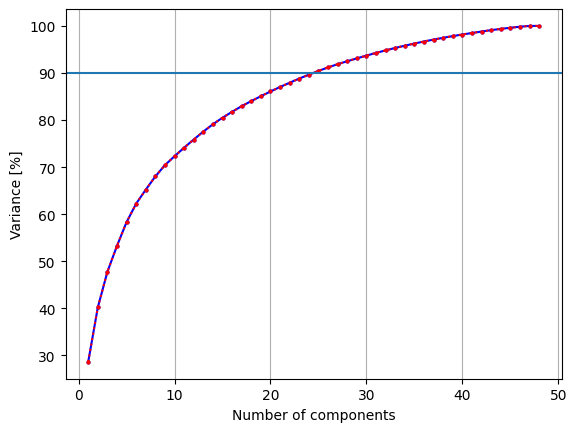

In [28]:
print(f"To obtain {ssm_obj.desired_variance*100}% variance, {ssm_obj.required_mode_number} modes are required")
plot_cumulative_variance(np.cumsum(ssm_obj.pca_object.explained_variance_ratio_), svd_cumsum, target_variance=0.9)

Now the interesting part. We visualise the first three principal components, where the points are coloured by their displacement. 

explained variance is 0.2862721047372064


pyssam-PCA: mean offset dist is 0.2719707743809857


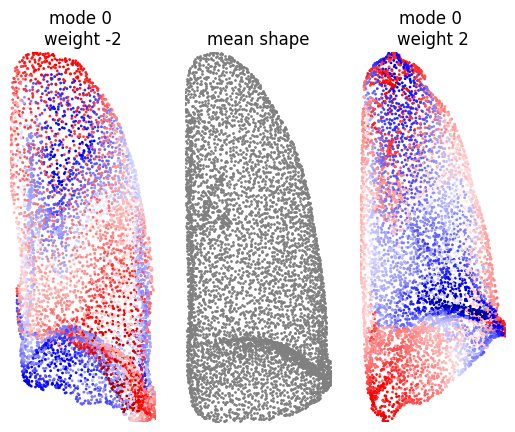

dev-SVD: mean offset dist is 0.20417676321868086


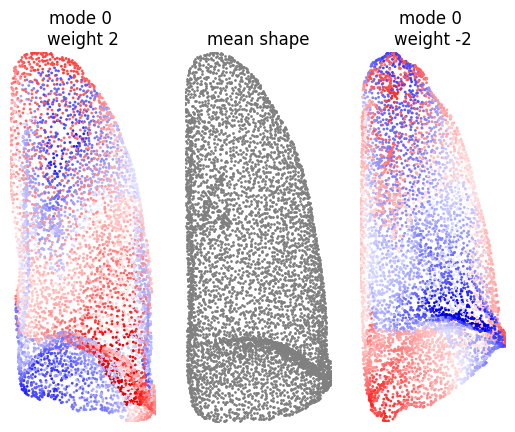

In [29]:
mode_to_plot = 0 
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}\n\n")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
    mode_to_plot,
)
dev_plot_shape_modes(mean_shape_columnvector, mean_shape, svd_values, mode_to_plot)

explained variance is 0.11562461259525639


pyssam-PCA: mean offset dist is 0.17706746017524383


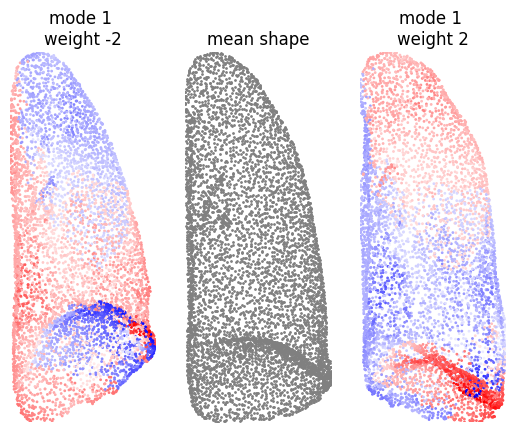

dev-SVD: mean offset dist is 0.16674584461296982


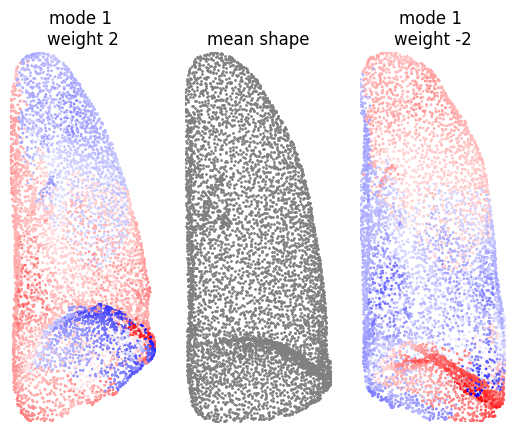

In [30]:
mode_to_plot = 1
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}\n\n")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
    mode_to_plot,
)
dev_plot_shape_modes(mean_shape_columnvector, mean_shape, svd_values, mode_to_plot)

explained variance is 0.07577465318882828


pyssam-PCA: mean offset dist is 0.1370687704608416


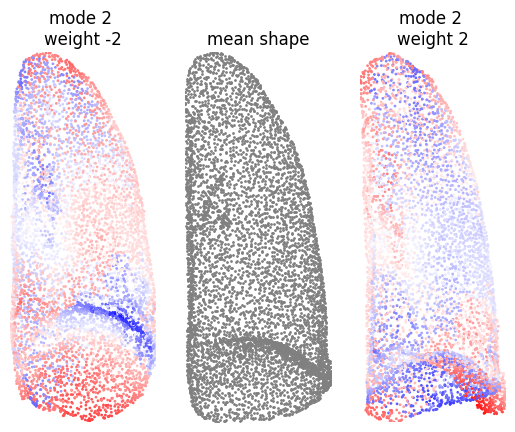

dev-SVD: mean offset dist is 0.14346182867940466


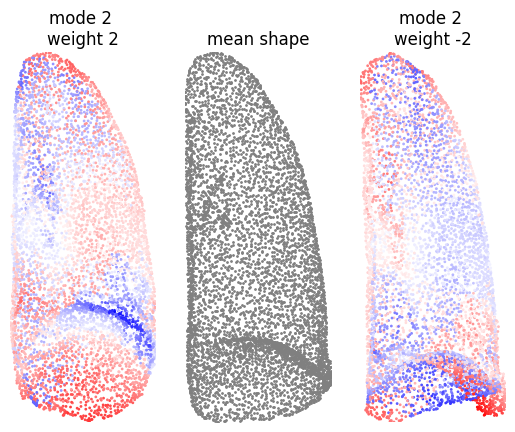

In [31]:
mode_to_plot = 2
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}\n\n")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
    mode_to_plot,
)
dev_plot_shape_modes(mean_shape_columnvector, mean_shape, svd_values, mode_to_plot)

When we look at the 15th mode, which accounts for around 1% for the total variance, we can see a very minor change in the lung structure (shown by very light red and blue patches).

explained variance is 0.012525399253420878


pyssam-PCA: mean offset dist is 0.05740007819798636


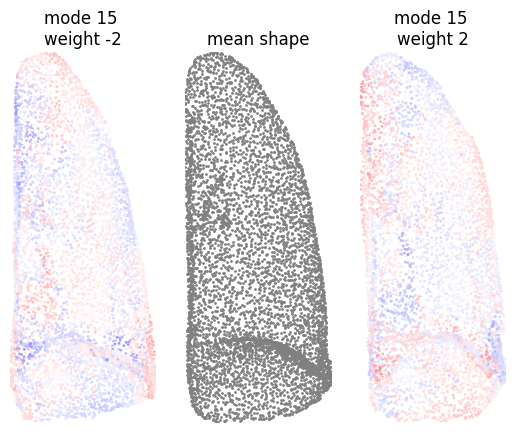

dev-SVD: mean offset dist is 0.09422007035348354


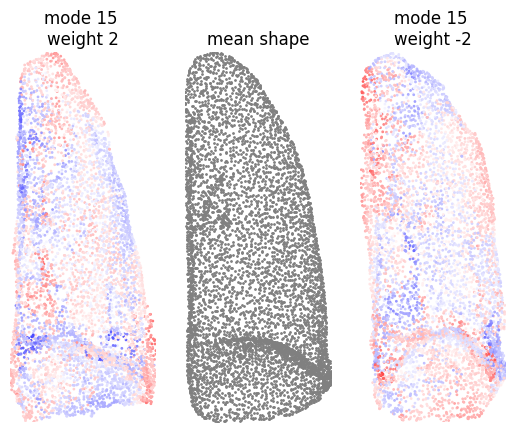

In [32]:
mode_to_plot = 15
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}\n\n")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
    mode_to_plot,
)
dev_plot_shape_modes(mean_shape_columnvector, mean_shape, svd_values, mode_to_plot)